# Flood Model Training Notebook

Train a Flood ConvLSTM Model using `usl_models` lib.

In [ ]:

# import tensorflow as tf
# import keras_tuner
# import time
# import keras
# import logging
# from usl_models.flood_ml import constants
# from usl_models.flood_ml.model import FloodModel
# from usl_models.flood_ml.model_params import FloodModelParams
# from usl_models.flood_ml.dataset import load_dataset_windowed, load_dataset
# import os
# # Setup
# logging.getLogger().setLevel(logging.WARNING)
# keras.utils.set_random_seed(812)

# for gpu in tf.config.list_physical_devices('GPU'):
#     tf.config.experimental.set_memory_growth(gpu, True)
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# # os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   
# # timestamp = time.strftime("%Y%m%d-%H%M%S")
# # def filter_by_mean_label_value(dataset, mean_threshold=0.001):
# #     """Keep samples where the mean of the label tensor ≤ threshold."""
# #     def filter_fn(input_dict, label):
# #         return tf.reduce_mean(label) <= mean_threshold
# #     return dataset.filter(filter_fn)

# # def mask_outliers_in_label(dataset, outlier_threshold=0.02):
# #     """Zero out or NaN out pixels above threshold in the label tensor."""
# #     def map_fn(input_dict, label):
# #         mask = label <= outlier_threshold
# #         masked_label = tf.where(mask, label, tf.zeros_like(label))  # or tf.constant(np.nan)
# #         return input_dict, masked_label
# #     return dataset.map(map_fn)

# # Cities and their config folders
# city_config_mapping = {
#     "Manhattan": "Manhattan_config",
#    "Atlanta": "Atlanta_config",
#     "Phoenix_SM": "PHX_SM",
#     "Phoenix_PV": "PHX_PV",
#     "Phoenix_central":"PHX_CCC",
# }

# # Rainfall files you want
# rainfall_files = [5, 6]  # Only 5 and 6

# # Generate sim_names
# sim_names = []
# for city, config in city_config_mapping.items():
#     for rain_id in rainfall_files:
#         sim_name = f"{city}-{config}/Rainfall_Data_{rain_id}.txt"
#         sim_names.append(sim_name)

# print(f"Training on {len(sim_names)} simulations.")
# for s in sim_names:
#     print(s)

# # Now load dataset
# train_dataset = load_dataset_windowed(
#     sim_names=sim_names,
#     batch_size=4,
#     dataset_split='train'
# ).cache()

# validation_dataset = load_dataset_windowed(
#     sim_names=sim_names,
#     batch_size=4,
#     dataset_split='val'
# ).cache()

# # print("\n=== Sample mean flood values BEFORE filtering train ===")
# # for i, (_, label) in enumerate(train_dataset.take(20)):
# #     print(f"Sample {i}: mean flood = {tf.reduce_mean(label).numpy():.5f}")

# # print("\n=== Sample mean flood values BEFORE filtering val ===")
# # for i, (_, label) in enumerate(validation_dataset.take(20)):
# #     print(f"Sample {i}: mean flood = {tf.reduce_mean(label).numpy():.5f}")

# # Filter and cache
# # train_dataset = filter_by_mean_label_value(train_dataset, mean_threshold=0.001)
# # train_dataset = mask_outliers_in_label(train_dataset, outlier_threshold=0.02)

# # validation_dataset = filter_by_mean_label_value(validation_dataset, mean_threshold=0.001)
# # validation_dataset = mask_outliers_in_label(validation_dataset, outlier_threshold=0.02)

# # Count examples to ensure not empty
# n_train = sum(1 for _ in train_dataset)
# n_val = sum(1 for _ in validation_dataset)
# # print(f"Filtered training samples: {n_train}")
# # print(f"Filtered validation samples: {n_val}")


# if n_train == 0 or n_val == 0:
#     raise ValueError("Filtered dataset is empty! Lower threshold or check label range.")




# # import numpy as np
# # import matplotlib.pyplot as plt

# # # Collect all label pixel values (flattened) from train and val
# # all_values = []

# # for dataset in [train_dataset, validation_dataset]:
# #     for _, label in dataset.take(20):  # limit to first 20 samples
# #         label_np = label.numpy()
# #         all_values.append(label_np.flatten())

# # # Concatenate all into a single 1D array
# # flood_pixels = np.concatenate(all_values)
# # flood_pixels = flood_pixels[~np.isnan(flood_pixels)]  # remove NaNs

# # # Histogram (linear scale)
# # plt.figure(figsize=(10, 4))
# # plt.hist(flood_pixels, bins=100, color="steelblue", alpha=0.8)
# # plt.title("Flood Depth Distribution (linear scale)")
# # plt.xlabel("Flood Depth (m)")
# # plt.ylabel("Pixel Count")
# # plt.grid(True)
# # plt.show()

# # # Histogram (log scale)
# # plt.figure(figsize=(10, 4))
# # plt.hist(flood_pixels, bins=100, color="tomato", alpha=0.8, log=True)
# # plt.title("Flood Depth Distribution (log scale)")
# # plt.xlabel("Flood Depth (m)")
# # plt.ylabel("Log Pixel Count")
# # plt.grid(True)
# # plt.show()


In [1]:
import tensorflow as tf
import keras_tuner
import time
import keras
import logging
from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml.model_params import FloodModelParams
from usl_models.flood_ml.dataset import load_dataset_windowed, load_dataset
import os

# Setup
logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

timestamp = time.strftime("%Y%m%d-%H%M%S")
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   
# timestamp = time.strftime("%Y%m%d-%H%M%S")

# Cities and their config folders (5 cities total)
city_config_mapping = {
    "Manhattan": "Manhattan_config",
    # "Atlanta": "Atlanta_config",
    # "Phoenix_SM": "PHX_SM",
    # "Phoenix_Central": "PHX_CCC",
    # "Phoenix_PV": "PHX_PV",

}

# We want exactly 5 rainfall scenarios, one per city
rainfall_scenarios = [2]

# Build sim_names by pairing each city with its corresponding rainfall ID
sim_names = []
for (city, config), rain_id in zip(city_config_mapping.items(), rainfall_scenarios):
    sim_name = f"{city}-{config}/Rainfall_Data_{rain_id}.txt"
    sim_names.append(sim_name)

print(f"Training on {len(sim_names)} simulations.")
for s in sim_names:
    print(s)

# Now load dataset
train_dataset = (
    load_dataset_windowed(
        sim_names=sim_names,
        batch_size=4,
        dataset_split='train'
    )
    .cache()
)

validation_dataset = (
    load_dataset_windowed(
        sim_names=sim_names,
        batch_size=4,
        dataset_split='val'
    )
    .cache()
)

# Count examples to ensure not empty
n_train = sum(1 for _ in train_dataset)
n_val = sum(1 for _ in validation_dataset)

if n_train == 0 or n_val == 0:
    raise ValueError("Filtered dataset is empty! Lower threshold or check label range.")


2025-06-11 20:58:45.273446: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 20:58:45.323895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-11 20:58:45.323929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-11 20:58:45.325141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-11 20:58:45.333489: I tensorflow/core/platform/cpu_feature_guar

Training on 1 simulations.
Manhattan-Manhattan_config/Rainfall_Data_2.txt


2025-06-11 20:58:50.564125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38483 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2025-06-11 20:58:50.565520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38483 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:05.0, compute capability: 8.0


In [ ]:
train_dataset=train_dataset.take(4)


In [ ]:
# print("Flood Pixel Statistics:")
# print(f"Min: {flood_pixels.min():.4f}")
# print(f"Mean: {flood_pixels.mean():.4f}")
# print(f"Median: {np.median(flood_pixels):.4f}")
# print(f"Max: {flood_pixels.max():.4f}")
# print(f"90th percentile: {np.percentile(flood_pixels, 90):.4f}")
# print(f"99th percentile: {np.percentile(flood_pixels, 99):.4f}")
# print(f"99.9th percentile: {np.percentile(flood_pixels, 99.9):.4f}")


In [ ]:
# import tensorflow as tf
# import numpy as np
# from collections import defaultdict

# # Define flood mean ranges
# value_ranges = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1.0, np.inf]
# range_labels = [f"≤{r:.3f}" if r != np.inf else ">1.0" for r in value_ranges]

# def count_samples_by_mean_range(dataset, name="train", max_samples=1000):
#     counter = defaultdict(int)
#     total = 0

#     for i, (_, label) in enumerate(dataset.take(max_samples)):
#         label_np = label.numpy()
#         label_mean = np.mean(label_np)

#         for threshold, label_str in zip(value_ranges, range_labels):
#             if label_mean <= threshold:
#                 counter[label_str] += 1
#                 break
#         total += 1

#     print(f"\n=== {name.capitalize()} Samples by Mean Flood Range (first {total}) ===")
#     for label_str in range_labels:
#         count = counter[label_str]
#         pct = 100 * count / total if total else 0
#         print(f"{label_str:>6}: {count:>4} samples ({pct:.1f}%)")
#     return counter

# # Run this for both datasets
# count_samples_by_mean_range(train_dataset, name="train")
# count_samples_by_mean_range(validation_dataset, name="validation")


In [2]:

tuner = keras_tuner.BayesianOptimization(
    FloodModel.get_hypermodel(
        lstm_units=[128],
        lstm_kernel_size=[3],
        lstm_dropout=[0.2],
        lstm_recurrent_dropout=[0.3],
        n_flood_maps=[5],
        m_rainfall=[6],
    ),
        objective="val_loss",
        max_trials=1,
        project_name=f"logs/htune_project_{timestamp}",
)

tuner.search_space_summary()


2025-06-11 20:59:25.920702: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Search space summary
Default search space size: 6
lstm_units (Choice)
{'default': 128, 'conditions': [], 'values': [128], 'ordered': True}
lstm_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3], 'ordered': True}
lstm_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2], 'ordered': True}
lstm_recurrent_dropout (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3], 'ordered': True}
n_flood_maps (Choice)
{'default': 5, 'conditions': [], 'values': [5], 'ordered': True}
m_rainfall (Choice)
{'default': 6, 'conditions': [], 'values': [6], 'ordered': True}


In [3]:
log_dir = f"logs/htune_project_{timestamp}"
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
tuner.search(train_dataset, epochs=10, validation_data=validation_dataset , callbacks=[tb_callback])
best_model, best_hp = tuner.get_best_models()[0], tuner.get_best_hyperparameters()[0]
best_hp.values

Trial 1 Complete [00h 03m 30s]
val_loss: 0.0006919301813468337

Best val_loss So Far: 0.0006919301813468337
Total elapsed time: 00h 03m 30s


{'lstm_units': 128,
 'lstm_kernel_size': 3,
 'lstm_dropout': 0.2,
 'lstm_recurrent_dropout': 0.3,
 'n_flood_maps': 5,
 'm_rainfall': 6}

In [4]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define final parameters and model
final_params = FloodModel.Params(**best_hp.values)
model = FloodModel(params=final_params)

# Define callbacks
callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        filepath=log_dir + "/checkpoint",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        save_format="tf"
    ),
    EarlyStopping(               # <--- ADD THIS
        monitor="val_loss",       # What to monitor
        patience=30,              # Number of epochs with no improvement to wait
        restore_best_weights=True, # Restore model weights from best epoch
        mode="min"                # "min" because lower val_loss is better
    )
]

# Train
model.fit(
    train_dataset,
    validation_dataset,
    epochs=3,
    callbacks=callbacks
)

# Save final model
model.save_model(log_dir + "/model")


Epoch 1/3


2025-06-11 21:03:21.702025: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inflood_conv_lstm_1/sequential_6/conv_lstm2d_1/while/body/_1/flood_conv_lstm_1/sequential_6/conv_lstm2d_1/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


     49/Unknown - 21s 313ms/step - loss: 0.0011 - mean_absolute_error: 0.0085 - root_mean_squared_error: 0.0456

2025-06-11 21:03:38.909400: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3209154723686423368
2025-06-11 21:03:42.033822: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7192193950557693275


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Assets written to: logs/htune_project_20250611-205848/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250611-205848/checkpoint/assets


49/49 [==============================] - 29s 473ms/step - loss: 0.0011 - mean_absolute_error: 0.0085 - root_mean_squared_error: 0.0456 - val_loss: 0.0013 - val_mean_absolute_error: 0.0134 - val_root_mean_squared_error: 0.0488
Epoch 2/3
49/49 [==============================] - ETA: 0s - loss: 9.6234e-04 - mean_absolute_error: 0.0076 - root_mean_squared_error: 0.0426INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Assets written to: logs/htune_project_20250611-205848/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250611-205848/checkpoint/assets


49/49 [==============================] - 22s 450ms/step - loss: 9.6234e-04 - mean_absolute_error: 0.0076 - root_mean_squared_error: 0.0426 - val_loss: 0.0011 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0455
Epoch 3/3
49/49 [==============================] - ETA: 0s - loss: 8.7779e-04 - mean_absolute_error: 0.0071 - root_mean_squared_error: 0.0403INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Assets written to: logs/htune_project_20250611-205848/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250611-205848/checkpoint/assets


49/49 [==============================] - 22s 456ms/step - loss: 8.7779e-04 - mean_absolute_error: 0.0071 - root_mean_squared_error: 0.0403 - val_loss: 0.0011 - val_mean_absolute_error: 0.0104 - val_root_mean_squared_error: 0.0435
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d7040df90>, 140176732128624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d701c4510>, 140176732128960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d68504810>, 140176731049296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7d6850b990>, 140176731049632), {}).


INFO:tensorflow:Assets written to: logs/htune_project_20250611-205848/model/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250611-205848/model/assets


In [ ]:
# Test calling the model on some data.
inputs, labels_ = next(iter(train_dataset))
prediction = model.call(inputs)
prediction.shape

In [ ]:
@keras.saving.register_keras_serializable()
def weighted_mse_small_targets(y_true, y_pred):
    """Custom MSE loss that gives higher importance to smaller target values."""
    # Ignore NaNs (if any) in labels
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    y_true = tf.where(mask, y_true, tf.zeros_like(y_true))
    y_pred = tf.where(mask, y_pred, tf.zeros_like(y_pred))

    # Define inverse-weighting: smaller values get higher weight
    weights = 1.0 / (1.0 + 100.0 * y_true)  # e.g., 0.001 -> ~1, 0.1 -> ~0.09
    squared_error = tf.square(y_true - y_pred)
    weighted_squared_error = weights * squared_error

    # Normalize by number of valid entries
    return tf.reduce_sum(weighted_squared_error) / tf.reduce_sum(
        tf.cast(mask, tf.float32)
    )

@keras.saving.register_keras_serializable()
def hybrid_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    small_weighted = weighted_mse_small_targets(y_true, y_pred)
    return 0.5 * mse + 0.5 * small_weighted


In [6]:

import tensorflow as tf
# Path to your saved model
model_path = "/home/jainr/climateiq-cnn-6/logs/htune_project_20250611-205848/model"

loaded_model = tf.keras.models.load_model(model_path)
loaded_model.summary()
# Load the model
# model = tf.keras.models.load_model(model_path)
# model = FloodModel.from_checkpoint(model_path)

Model: "flood_conv_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, None, 250, 250,    3424      
                             16)                                 
                                                                 
 sequential_5 (Sequential)   (None, 250, 250, 64)      29280     
                                                                 
 spatial_attention_2 (Spati  multiple                  99        
 alAttention)                                                    
                                                                 
 sequential_6 (Sequential)   (None, 250, 250, 128)     986624    
                                                                 
 spatial_attention_3 (Spati  multiple                  99        
 alAttention)                                                    
                                                 

In [17]:
from usl_models.flood_ml.model import SpatialAttention
custom_objects = {'SpatialAttention': SpatialAttention}
loaded_model = tf.keras.models.load_model(
    model_path,
    custom_objects=custom_objects,
    compile=False
)
model._model.set_weights(loaded_model.get_weights())

In [19]:
# # Test calling the model for n predictions
full_dataset = load_dataset(sim_names=sim_names, batch_size=4, dataset_split= "train")

inputs, labels = next(iter(full_dataset))
predictions = model.call_n(inputs, n=4)
predictions.shape

TensorShape([4, 4, 1000, 1000])

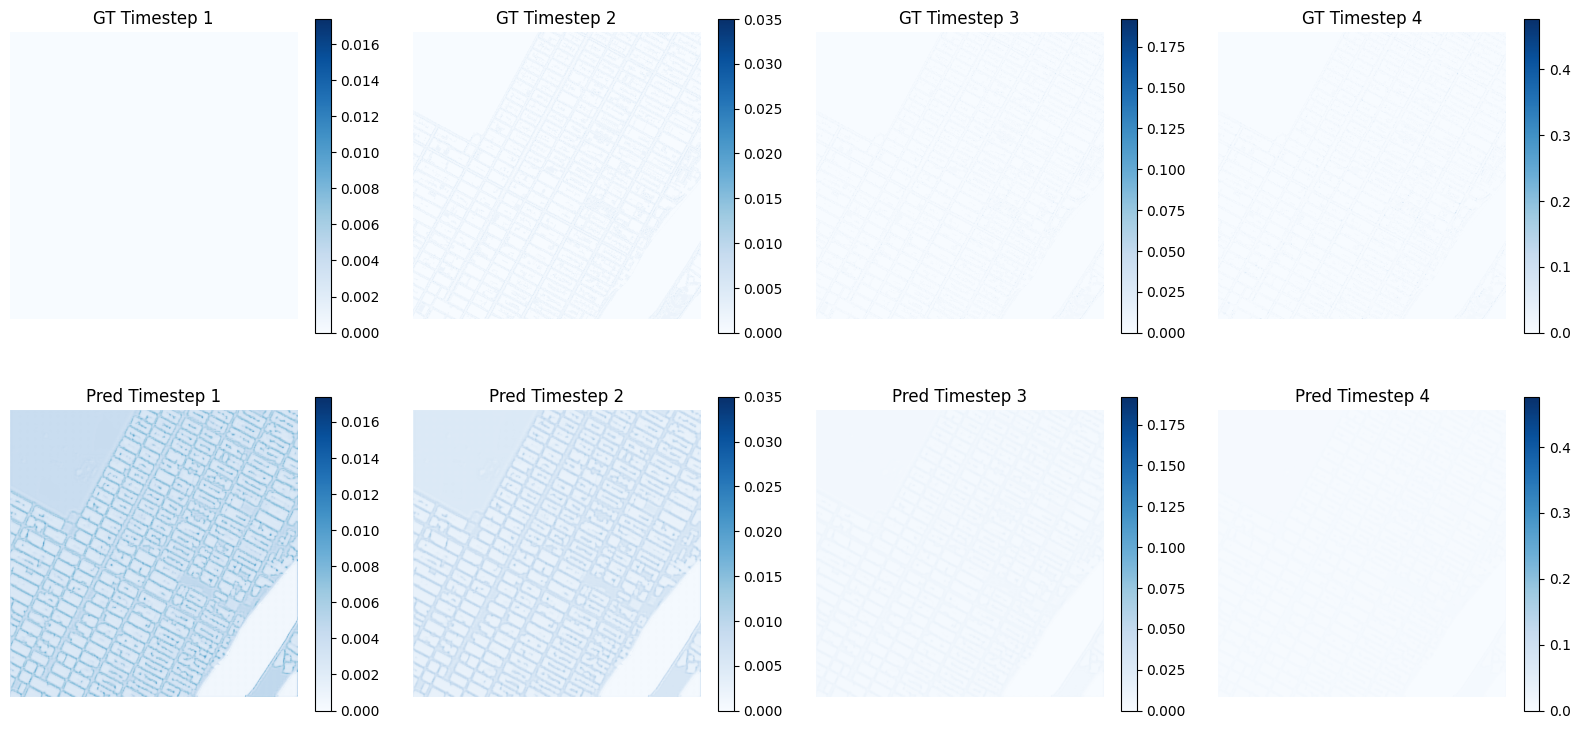

In [28]:
import matplotlib.pyplot as plt

# Take one batch from dataset
inputs, ground_truth = next(iter(full_dataset))  # or train_dataset

# Make prediction
predictions = model.call_n(inputs, n=4).numpy()
ground_truth = ground_truth.numpy()

# Select a sample from the batch
batch_index = 0
n_timesteps = predictions.shape[1]

fig, axes = plt.subplots(2, n_timesteps, figsize=(4 * n_timesteps, 8))

for t in range(n_timesteps):
    # Common vmax for consistent color scaling
    vmax_val = max(
        ground_truth[batch_index, t, :, :].max(),
        predictions[batch_index, t, :, :].max()
    )

    # Ground Truth
    ax_gt = axes[0, t]
    im_gt = ax_gt.imshow(ground_truth[batch_index, t, :, :], cmap='Blues', vmin=0, vmax=vmax_val)
    ax_gt.set_title(f'GT Timestep {t+1}')
    ax_gt.axis('off')
    plt.colorbar(im_gt, ax=ax_gt, shrink=0.8)

    # Prediction
    ax_pred = axes[1, t]
    im_pred = ax_pred.imshow(predictions[batch_index, t, :, :], cmap='Blues', vmin=0, vmax=vmax_val)
    ax_pred.set_title(f'Pred Timestep {t+1}')
    ax_pred.axis('off')
    plt.colorbar(im_pred, ax=ax_pred, shrink=0.8)

plt.tight_layout()
plt.show()


In [6]:
loaded_model = keras.models.load_model(model_path)
loaded_model.summary()

Model: "flood_conv_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, None, 250, 250,    3424      
                             16)                                 
                                                                 
 sequential_5 (Sequential)   (None, 250, 250, 64)      29280     
                                                                 
 spatial_attention_2 (Spati  multiple                  99        
 alAttention)                                                    
                                                                 
 sequential_6 (Sequential)   (None, 250, 250, 32)      136064    
                                                                 
 spatial_attention_3 (Spati  multiple                  99        
 alAttention)                                                    
                                                 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from usl_models.flood_ml.dataset import load_dataset_windowed
from usl_models.flood_ml import constants

# # Path to trained model
# model_path = "/home/elhajjas/climateiq-cnn-4/usl_models/notebooks/logs/htune_project_20250508-202940/model"
# model = tf.keras.models.load_model(model_path)

# Number of samples to visualize
n_samples = 20

# Loop through the dataset and predict
for i, (input_data, ground_truth) in enumerate(train_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    prediction = model(input_data).numpy().squeeze()

    print(f"\nSample {i+1} Prediction Stats:")
    print("  Min:", prediction.min())
    print("  Max:", prediction.max())
    print("  Mean:", prediction.mean())

    # Choose timestep to plot
    timestep = 3
    gt_t = ground_truth[timestep]
    pred_t = prediction[timestep]
    vmax_val = max(gt_t.max(), pred_t.max())

    # Plot Ground Truth and Prediction
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im1 = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.colorbar(im2, ax=axes[1], shrink=0.8)

    plt.tight_layout()
    plt.show()


In [ ]:
# pip install scikit-image


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# Load your trained model
model_path = "/home/jainr/climateiq-cnn-6/usl_models/notebooks/logs/htune_project_20250602-051617/model"
def weighted_mse_small_targets(y_true, y_pred):
    """
    Custom MSE loss that gives higher importance to smaller target values.
    Very useful when trying to make the model learn subtle signals like 0.001 depth floods.
    """
    # Ignore NaNs (if any) in labels
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    y_true = tf.where(mask, y_true, tf.zeros_like(y_true))
    y_pred = tf.where(mask, y_pred, tf.zeros_like(y_pred))

    # Define inverse-weighting: smaller values get higher weight
    weights = 1.0 / (1.0 + 100.0 * y_true)  # e.g., 0.001 -> ~1, 0.1 -> ~0.09
    squared_error = tf.square(y_true - y_pred)
    weighted_squared_error = weights * squared_error

    # Normalize by number of valid entries
    return tf.reduce_sum(weighted_squared_error) / tf.reduce_sum(tf.cast(mask, tf.float32))

def hybrid_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    small_weighted = weighted_mse_small_targets(y_true, y_pred)
    return 0.5 * mse + 0.5 * small_weighted
model = tf.keras.models.load_model(model_path, custom_objects={"hybrid_loss": hybrid_loss})


# Assuming validation_dataset is already defined
# Example:
# from usl_models.flood_ml.dataset import load_dataset_windowed
# validation_dataset = load_dataset_windowed(...)

n_samples = 40
timestep = 2
metrics_list = []

for i, (input_data, ground_truth) in enumerate(validation_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    prediction = model(input_data).numpy().squeeze()

    gt_t = ground_truth[timestep]
    pred_t = prediction[timestep]
    vmax_val = np.nanpercentile([gt_t, pred_t], 99.5)

    # Mask out NaNs
    mask = ~np.isnan(gt_t)
    gt_flat = gt_t[mask].flatten()
    pred_flat = pred_t[mask].flatten()

    mae = mean_absolute_error(gt_flat, pred_flat)
    rmse = np.sqrt(mean_squared_error(gt_flat, pred_flat))
    bias = np.mean(pred_flat) - np.mean(gt_flat)
    iou = np.logical_and(gt_flat > 0.1, pred_flat > 0.1).sum() / max(1, np.logical_or(gt_flat > 0.1, pred_flat > 0.1).sum())
    ssim_val = ssim(gt_t, pred_t, data_range=gt_t.max() - gt_t.min())

    metrics_list.append({
        "Sample": i+1,
        "MAE": mae,
        "RMSE": rmse,
        "Bias": bias,
        "IoU > 0.1": iou,
        "SSIM": ssim_val
    })

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im1 = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.colorbar(im2, ax=axes[1], shrink=0.8)

    plt.tight_layout()
    plt.show()

# Convert to DataFrame
df = pd.DataFrame(metrics_list)
print("\n=== Metrics Summary ===")
print(df.describe())


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# === Custom loss ===
def weighted_mse_small_targets(y_true, y_pred):
    """
    Custom MSE loss that gives higher weight to small target values.
    Emphasizes learning small flood depths like 0.001–0.03 more than high values.
    """
    weights = 1.0 / (1.0 + tf.square(y_true * 10))  # Scale emphasis on smaller targets
    squared_error = tf.square(y_true - y_pred)
    weighted_error = weights * squared_error
    return tf.reduce_mean(weighted_error)

# === Load all models ===
model_paths = {
    "Baseline": "/home/elhajjas/climateiq-cnn-4/logs/baselineManhattan50epochs20tuner/model",
    "Attentionafterconvlstm": "logs/htune_project_20250522-150650/model",
    "Attentionbeforeandafterconvlstm": "/home/elhajjas/climateiq-cnn-4/usl_models/notebooks/logs/attentionbeforeandafterconvlstm50epochsjustManh/model"
}

models = {
    name: tf.keras.models.load_model(path, custom_objects={"weighted_mse_small_targets": weighted_mse_small_targets})
    for name, path in model_paths.items()
}

# === Evaluation setup ===
n_samples = 20
timestep = 3
metrics_list = []

# Loop through validation data (adjust this to your dataset)
for i, (input_data, ground_truth) in enumerate(validation_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    model_preds = {name: model(input_data).numpy().squeeze() for name, model in models.items()}
    
    gt_t = ground_truth[timestep]
    vmax_val = np.nanpercentile([gt_t] + [pred[timestep] for pred in model_preds.values()], 99.5)
    mask = ~np.isnan(gt_t)
    gt_flat = gt_t[mask].flatten()

    sample_metrics = {"Sample": i+1}

    # === Visualization ===
    fig, axes = plt.subplots(1, len(models) + 1, figsize=(7 * (len(models) + 1), 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im, ax=axes[0], shrink=0.8)

    for j, (name, pred) in enumerate(model_preds.items(), 1):
        pred_t = pred[timestep]
        pred_flat = pred_t[mask].flatten()

        sample_metrics[f"{name} MAE"] = mean_absolute_error(gt_flat, pred_flat)
        sample_metrics[f"{name} RMSE"] = np.sqrt(mean_squared_error(gt_flat, pred_flat))
        sample_metrics[f"{name} Bias"] = np.mean(pred_flat) - np.mean(gt_flat)
        sample_metrics[f"{name} IoU > 0.1"] = np.logical_and(gt_flat > 0.1, pred_flat > 0.1).sum() / max(
            1, np.logical_or(gt_flat > 0.1, pred_flat > 0.1).sum())
        sample_metrics[f"{name} SSIM"] = ssim(gt_t, pred_t, data_range=gt_t.max() - gt_t.min())

        im = axes[j].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
        axes[j].set_title(f"{name} Prediction")
        axes[j].axis("off")
        plt.colorbar(im, ax=axes[j], shrink=0.8)

    metrics_list.append(sample_metrics)
    plt.tight_layout()
    plt.show()

# === Summary ===
df = pd.DataFrame(metrics_list)
print("\n=== Metrics Summary ===")
print(df.describe())


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# Load your trained model
model_path = "/home/elhajjas/climateiq-cnn-4/logs/baselineManhattan50epochs20tuner/model"
model = tf.keras.models.load_model(model_path)

# Assuming validation_dataset is already defined
# Example:
# from usl_models.flood_ml.dataset import load_dataset_windowed
# validation_dataset = load_dataset_windowed(...)

n_samples = 20
timestep = 3
metrics_list = []

for i, (input_data, ground_truth) in enumerate(validation_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    prediction = model(input_data).numpy().squeeze()

    gt_t = ground_truth[timestep]
    pred_t = prediction[timestep]
    vmax_val = np.nanpercentile([gt_t, pred_t], 99.5)

    # Mask out NaNs
    mask = ~np.isnan(gt_t)
    gt_flat = gt_t[mask].flatten()
    pred_flat = pred_t[mask].flatten()

    mae = mean_absolute_error(gt_flat, pred_flat)
    rmse = np.sqrt(mean_squared_error(gt_flat, pred_flat))
    bias = np.mean(pred_flat) - np.mean(gt_flat)
    iou = np.logical_and(gt_flat > 0.1, pred_flat > 0.1).sum() / max(1, np.logical_or(gt_flat > 0.1, pred_flat > 0.1).sum())
    ssim_val = ssim(gt_t, pred_t, data_range=gt_t.max() - gt_t.min())

    metrics_list.append({
        "Sample": i+1,
        "MAE": mae,
        "RMSE": rmse,
        "Bias": bias,
        "IoU > 0.1": iou,
        "SSIM": ssim_val
    })

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im1 = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.colorbar(im2, ax=axes[1], shrink=0.8)

    plt.tight_layout()
    plt.show()

# Convert to DataFrame
df = pd.DataFrame(metrics_list)
print("\n=== Metrics Summary ===")
print(df.describe())


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# Load all models
model_paths = {
    "Baseline": "/home/elhajjas/climateiq-cnn-4/logs/baselineManhattan50epochs20tuner/model",
    "Attentionafterconvlstm": "logs/htune_project_20250522-150650/model",
    "Attentionbeforeandafterconvlstm": "/home/elhajjas/climateiq-cnn-4/usl_models/notebooks/logs/attentionbeforeandafterconvlstm50epochsjustManh/model"
}
models = {name: tf.keras.models.load_model(path) for name, path in model_paths.items()}

# Adjust as needed for your dataset
n_samples = 20
timestep = 3
metrics_list = []

for i, (input_data, ground_truth) in enumerate(train_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    model_preds = {name: model(input_data).numpy().squeeze() for name, model in models.items()}
    
    gt_t = ground_truth[timestep]
    vmax_val = np.nanpercentile([gt_t] + [pred[timestep] for pred in model_preds.values()], 99.5)
    mask = ~np.isnan(gt_t)
    gt_flat = gt_t[mask].flatten()
    
    sample_metrics = {"Sample": i + 1}
    fig, axes = plt.subplots(1, len(models) + 1, figsize=(7 * (len(models) + 1), 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im, ax=axes[0], shrink=0.8)

    for j, (name, pred) in enumerate(model_preds.items(), 1):
        pred_t = pred[timestep]
        pred_flat = pred_t[mask].flatten()

        sample_metrics[f"{name} MAE"] = mean_absolute_error(gt_flat, pred_flat)
        sample_metrics[f"{name} RMSE"] = np.sqrt(mean_squared_error(gt_flat, pred_flat))
        sample_metrics[f"{name} Bias"] = np.mean(pred_flat) - np.mean(gt_flat)
        sample_metrics[f"{name} IoU > 0.1"] = np.logical_and(gt_flat > 0.1, pred_flat > 0.1).sum() / max(
            1, np.logical_or(gt_flat > 0.1, pred_flat > 0.1).sum())
        sample_metrics[f"{name} SSIM"] = ssim(gt_t, pred_t, data_range=gt_t.max() - gt_t.min())

        im = axes[j].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
        axes[j].set_title(f"{name} Prediction")
        axes[j].axis("off")
        plt.colorbar(im, ax=axes[j], shrink=0.8)

    metrics_list.append(sample_metrics)
    plt.tight_layout()
    plt.show()

# Create DataFrame and plot errors
# df = pd.DataFrame(metrics_list)
# df_plot = df.set_index("Sample")[[col for col in df.columns if "RMSE" in col or "MAE" in col]]
# df_plot.plot(kind="bar", figsize=(18, 6), title="RMSE and MAE by Model per Sample")
# plt.ylabel("Error Value")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# === Custom loss ===
def weighted_mse_small_targets(y_true, y_pred):
    weights = 1.0 / (1.0 + tf.square(y_true * 10))
    squared_error = tf.square(y_true - y_pred)
    weighted_error = weights * squared_error
    return tf.reduce_mean(weighted_error)

# === Paths for comparison ===
model_paths = {
    "Baseline": "/home/elhajjas/climateiq-cnn-4/logs/baselineManhattan50epochs20tuner/model",
    "Attentionafterconvlstm": "logs/htune_project_20250522-150650/model",
    "Attentionbeforeandafterconvlstm": "/home/elhajjas/climateiq-cnn-4/usl_models/notebooks/logs/attentionbeforeandafterconvlstm50epochsjustManh/model"
}

# === Evaluation setup ===
n_samples = 20
timestep = 3
metrics_list = []

for i, (input_data, ground_truth) in enumerate(validation_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    gt_t = ground_truth[timestep]
    mask = ~np.isnan(gt_t)
    gt_flat = gt_t[mask].flatten()

    sample_metrics = {"Sample": i + 1}
    preds = {}

    # Plot ground truth
    fig, axes = plt.subplots(1, len(model_paths) + 1, figsize=(7 * (len(model_paths) + 1), 6))
    fig.suptitle(f"Sample {i + 1} - Timestep {timestep}", fontsize=16)

    im = axes[0].imshow(gt_t, cmap="Blues")
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im, ax=axes[0], shrink=0.8)

    # Run predictions one-by-one to avoid OOM
    for j, (name, path) in enumerate(model_paths.items(), 1):
        tf.keras.backend.clear_session()
        model = tf.keras.models.load_model(path, custom_objects={"weighted_mse_small_targets": weighted_mse_small_targets})
        prediction = model(input_data).numpy().squeeze()
        pred_t = prediction[timestep]
        pred_flat = pred_t[mask].flatten()

        sample_metrics[f"{name} MAE"] = mean_absolute_error(gt_flat, pred_flat)
        sample_metrics[f"{name} RMSE"] = np.sqrt(mean_squared_error(gt_flat, pred_flat))
        sample_metrics[f"{name} Bias"] = np.mean(pred_flat) - np.mean(gt_flat)
        sample_metrics[f"{name} IoU > 0.1"] = np.logical_and(gt_flat > 0.1, pred_flat > 0.1).sum() / max(
            1, np.logical_or(gt_flat > 0.1, pred_flat > 0.1).sum())
        sample_metrics[f"{name} SSIM"] = ssim(gt_t, pred_t, data_range=gt_t.max() - gt_t.min())

        preds[name] = pred_t
        im = axes[j].imshow(pred_t, cmap="Blues", vmin=0, vmax=np.nanpercentile([gt_t] + list(preds.values()), 99.5))
        axes[j].set_title(f"{name} Prediction")
        axes[j].axis("off")
        plt.colorbar(im, ax=axes[j], shrink=0.8)

    metrics_list.append(sample_metrics)
    plt.tight_layout()
    plt.show()

# === Summary ===
df = pd.DataFrame(metrics_list)
print("\n=== Metrics Summary ===")
print(df.describe())


In [ ]:
import seaborn as sns

# Convert long-form for Seaborn
metric_names = ["MAE", "RMSE", "Bias", "IoU > 0.1", "SSIM"]
model_names = ["Baseline", "Attention"]

for metric in ["RMSE", "MAE"]:
    plt.figure(figsize=(10, 6))
    for model in model_names:
        sns.lineplot(data=df, x="Sample", y=f"{model} {metric}", label=f"{model} {metric}", marker="o")

    plt.title(f"{metric} Across Samples")
    plt.xlabel("Sample Index")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
df_melted = df.melt(id_vars=["Sample"], value_vars=[f"{m} RMSE" for m in model_names],
                    var_name="Model", value_name="RMSE")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Sample", y="RMSE", hue="Model")
plt.title("RMSE by Sample for Each Model")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import tensorflow as tf
import keras_tuner
import time
import keras
import logging
from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml.model_params import FloodModelParams
from usl_models.flood_ml.dataset import download_dataset, load_dataset_cached_windowed
import pathlib
import os

# Setup
logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

timestamp = time.strftime("%Y%m%d-%H%M%S")

# Cities and their config folders (5 cities total)
city_config_mapping = {
    "Manhattan": "Manhattan_config",
    "Atlanta": "Atlanta_config",
    "Phoenix_SM": "PHX_SM",
    "Phoenix_Central": "PHX_CCC",
    "Phoenix_PV": "PHX_PV",
}

# Specify rainfall scenarios
rainfall_scenarios = [5,6,7,8]

# Build simulation names
sim_names = [
    f"{city}-{config}/Rainfall_Data_{rain_id}.txt"
    for (city, config), rain_id in zip(city_config_mapping.items(), rainfall_scenarios)
]

print(f"Training on {len(sim_names)} simulations:")
for sim_name in sim_names:
    print(sim_name)

# Define local cache path
cache_dir = pathlib.Path("/home/shared")

# Download data from cloud and cache locally
for split in ['train', 'val']:
    download_dataset(
        sim_names=sim_names,
        dataset_split=split,
        output_path=cache_dir
    )

# Load cached datasets for training and validation
train_dataset = (
    load_dataset_cached_windowed(
        sim_names=sim_names,
        batch_size=4,
        dataset_split='train',
        filecache_dir=cache_dir
    ).cache()
)

validation_dataset = (
    load_dataset_cached_windowed(
        sim_names=sim_names,
        batch_size=4,
        dataset_split='val',
        filecache_dir=cache_dir
    ).cache()
)

# Verify dataset contents
n_train = sum(1 for _ in train_dataset)
n_val = sum(1 for _ in validation_dataset)

if n_train == 0 or n_val == 0:
    raise ValueError("Filtered dataset is empty! Lower threshold or check label range.")


Training on 4 simulations:
Manhattan-Manhattan_config/Rainfall_Data_5.txt
Atlanta-Atlanta_config/Rainfall_Data_6.txt
Phoenix_SM-PHX_SM/Rainfall_Data_7.txt
Phoenix_Central-PHX_CCC/Rainfall_Data_8.txt


PermissionError: [Errno 13] Permission denied: '/home/shared/Manhattan-Manhattan_config'